## Text Analytics Assignment 3
### POS Tagger with MLPs
***

#### Mounting GDrive to Colab


In [33]:
### Imports
import pickle
import numpy as np
import pandas as pd
from nltk.util import ngrams
from collections import OrderedDict as OD, Counter
from math import floor
from sklearn.metrics import *
!pip install keras-tuner
import kerastuner
from kerastuner.tuners import RandomSearch
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.dummy import DummyClassifier
from random import choices
from tqdm import tqdm

In [2]:
### We need to install conllu to read the pos-tagged files of the UL Dataset
!pip install conllu
import conllu
from conllu import parse,parse_incr

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Download, unzip & load Fasttext word embeddings (no need to re-run)
***

In [0]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# !gzip -d cc.en.300.vec.gz

### Load fasttext embeddings (no need to re-run)

In [0]:
# idx = 0
# vocab = {}
# with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n', errors='ignore') as f:
#     for l in f:
#         line = l.rstrip().split(' ')
#         if idx == 0:
#             vocab_size = int(line[0]) + 2 # Find Vocabulary size from header description at line 1
#             dim = int(line[1]) # Find embeddings dimensionality from header description at line 1 
#             vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
#             vocab["__PADDING__"] = 0 # Pad symbol index 0
#             vocab["__UNK__"] = 1 # Unk symbol index 1
#             idx = 2 # Skip one line
#         else:
#             vocab[line[0]] = idx
#             emb = np.array(line[1:]).astype(np.float)
#             if (emb.shape[0] == dim):
#                 vecs[idx,:] = emb
#                 idx+=1
#             else:
#                 continue

#     pickle.dump(vocab,open("/content/gdrive/My Drive/Fasttext/fasttext_voc.pkl" ,'wb')) # Save vocab Mapping
#     np.save("/content/gdrive/My Drive/Fasttext/fasttext.npy",vecs) # Save Numpy Matrix
#     # Release Memory
#     vecs = None
#     vocab = None
#     emb = None

### Load embeddings np-array and mapping dictionary.
***

In [0]:
fasttext_embed = np.load('/content/gdrive/My Drive/Fasttext/fasttext.npy')
fasttext_word_to_index = pickle.load(open('/content/gdrive/My Drive/Fasttext/fasttext_voc.pkl', 'rb'))

### Create Helper Functions and Load the Conllu Files from GDrive
***

In [0]:
def preprocessing(word):
  """
    Since we do not want to change vastly the dataset due to the POS Tagging Task,
    we procees with minimal preprocessing of replacing emails with symbol @
    and numbers with number 0.
  """
  word = str(word).lower()
  if word.isnumeric():
    return '0'

  if '@' in word:
    return '@'
  
  return word

In [0]:
def list_flat(alist):
  """
    Flattens a list of lists into a single list.
  """
  flat_list = []
  for sublist in alist:
      for item in sublist:
          flat_list.append(item)
  return flat_list

In [0]:
def convert_to_dataset(conllu_file):
  """
    Converts a Conllu File into Sentences and POS Tags.
  """
  data_file = open(conllu_file, "r", encoding="utf-8")
  sentences = []
  pos_tags = []
  length = []
  for tokenlist in parse_incr(data_file):
      sentence = [preprocessing(f['lemma']) for f in tokenlist]
      if len(sentence) > 2:
        tags = [f['upos'] for f in tokenlist]
        length.append(len(sentence))
        sentences.append(sentence)
        pos_tags.append(tags)

  min_length = floor(np.array(length).min())
  avg_length = floor(np.array(length).mean())
  print(f"Found {len(sentences)} sentences of min size {min_length} average size {avg_length} in the dataset!\n")

  return sentences, pos_tags

In [0]:
def convert_to_window_dataset(data, window_size, pad_symbol):
  """
    Converts Dataset from sentences to windows of words of size (window_size).
    Pads the Sentences in order to keep same window length across the creation
    of the sets.
  """
  z_sentences = data[0]
  z_pos_tags = list_flat(data[1])
  windowed_sentences = [] 
  for sentence in z_sentences:
      gen = ngrams(sentence, window_size, pad_left=True, pad_right=True, left_pad_symbol=pad_symbol, right_pad_symbol=pad_symbol)
      if window_size != 1:
        for f in list(gen)[window_size//2:-(window_size//2)]:
            windowed_sentences.append(f)
      else:
         for f in list(gen):
           windowed_sentences.append(f)
  return windowed_sentences, z_pos_tags

In [11]:
### Load the Datasets
train_data, train_pos_tags = convert_to_dataset('/content/gdrive/My Drive/Fasttext/Dataset/train.conllu')
dev_data, dev_pos_tags = convert_to_dataset('/content/gdrive/My Drive/Fasttext/Dataset/dev.conllu')
test_data, test_pos_tags = convert_to_dataset('/content/gdrive/My Drive/Fasttext/Dataset/test.conllu')

Found 4094 sentences of min size 3 average size 19 in the dataset!

Found 751 sentences of min size 3 average size 20 in the dataset!

Found 852 sentences of min size 3 average size 18 in the dataset!



In [0]:
### Get all the known labels and make a set in order to enumerate them
labels = {}
unique = set(list_flat(train_pos_tags))
for k,v in enumerate(sorted(unique)):
  labels.update({v:k})

In [13]:
### Theese are the target Categories!
labels

{'ADJ': 0,
 'ADP': 1,
 'ADV': 2,
 'AUX': 3,
 'CCONJ': 4,
 'DET': 5,
 'INTJ': 6,
 'NOUN': 7,
 'NUM': 8,
 'PART': 9,
 'PRON': 10,
 'PROPN': 11,
 'PUNCT': 12,
 'SCONJ': 13,
 'SYM': 14,
 'VERB': 15,
 'X': 16}

In [0]:
### Get all known words in train set and make a vocabulary out of them
### Add the Special Tokens
train_vocab = set(list_flat(train_data))
train_vocab = {v:k+2 for k,v in enumerate(sorted(train_vocab))}

train_vocab.update({'__PADDING__': 0})
train_vocab.update({'__UNK__': 1})

### Initialize embedding matrix with fasttext pre-trained embedings
***

In [15]:
MAX_WORDS = len(train_vocab) # instead of 2000000 + 2
# We dont need the full matrix just the number of words in our dataset.
# We try to limit this for RAM reasons.
print(f"Total Number of Words: {MAX_WORDS}\n")
EMBEDDING_DIM = fasttext_embed.shape[1]
print(f"Embedding Dimension: {EMBEDDING_DIM}\n")

Total Number of Words: 8746

Embedding Dimension: 300



In [0]:
embedding_matrix = np.random.uniform(low=-1,high=1, size=(MAX_WORDS, EMBEDDING_DIM))
for word, i in train_vocab.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

### Clean Memory
del fasttext_embed
del fasttext_word_to_index

### Prepare Datasets for Training / Tuning
***

In [0]:
### Tokenize Train/Dev/Test Sets

x_train_tokenized = []
for sentence in train_data:
    tokenized_sentence = []
    for token in sentence:
        if token in train_vocab:
            tokenized_sentence.append(train_vocab[token])
        else:
            tokenized_sentence.append(train_vocab['__UNK__'])
    x_train_tokenized.append(tokenized_sentence)

### Clean Memory
del train_data

x_dev_tokenized = []
for sentence in dev_data:
    tokenized_sentence = []
    for token in sentence:
        if token in train_vocab:
            tokenized_sentence.append(train_vocab[token])
        else:
            tokenized_sentence.append(train_vocab['__UNK__'])
    x_dev_tokenized.append(tokenized_sentence)

### Clean Memory
del dev_data



x_test_tokenized = []
for sentence in test_data:
    tokenized_sentence = []
    for token in sentence:
        if token in train_vocab:
            tokenized_sentence.append(train_vocab[token])
        else:
            tokenized_sentence.append(train_vocab['__UNK__'])
    x_test_tokenized.append(tokenized_sentence)

### Clean Memory
del test_data

In [0]:
### Convert Train/Dev/Test targets
y_train_tokenized = []
for sentence in train_pos_tags:
    tokenized_labels = []
    for label in sentence:
      tokenized_labels.append(labels[label])
    y_train_tokenized.append(tokenized_labels)

### Clean Memory
del train_pos_tags

y_dev_tokenized = []
for sentence in dev_pos_tags:
    tokenized_labels = []
    for label in sentence:
      tokenized_labels.append(labels[label])
    y_dev_tokenized.append(tokenized_labels)

### Clean Memory
del dev_pos_tags


y_test_tokenized = []
for sentence in test_pos_tags:
    tokenized_labels = []
    for label in sentence:
      tokenized_labels.append(labels[label])
    y_test_tokenized.append(tokenized_labels)

### Clean Memory
del test_pos_tags

### Create BaseLine Classifier
***


In [0]:
class CustomDummyClassifier:
    def __init__(self):
        self.occurance_dict = {}
        self.most_frequent = None
        return
    
    
    def _most_freq(self, x_array, y_array, idx):
        # Custom "Most Frequent" Calculator
        try:
            mf = Counter(y_array[x_array[:,0] == idx]).most_common(1)[0][0]
        except IndexError:
            # Nothing Found for Token
            return Counter(y_array).most_common(1)[0][0]
        return mf
    
    def fit(self,x_train,y_train,vocab_len=8746):
        self.most_frequent = Counter(y_train).most_common(1)[0][0]
        for i in range(0, vocab_len):
            mode = self._most_freq(x_train,y_train,i)
            self.occurance_dict.update({i:mode})
        return
    
    def predict(self, x_test):
        results = []
        assumed_window_size = x_test.shape[1]
        for x in x_test:
            ### Slice th input to get the middle item in a window
            x = x[assumed_window_size // 2] if assumed_window_size > 1 else x[0]
            if x in self.occurance_dict:
                results.append(self.occurance_dict[x])
            else:
                results.append(self.most_frequent)
        
        return np.array(results)

In [0]:
WINDOW_SIZE = 1
x_train, y_train = convert_to_window_dataset([x_train_tokenized, y_train_tokenized], WINDOW_SIZE, train_vocab['__PADDING__'])
x_test, y_test = convert_to_window_dataset([x_test_tokenized, y_test_tokenized], WINDOW_SIZE, train_vocab['__PADDING__'])

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train = np.array(y_train)
y_train = y_train.astype('int16')

x_test = np.array(x_test)
x_test = x_test.astype('float32')

y_test = np.array(y_test)
y_test = y_test.astype('int16')

In [112]:
base = CustomDummyClassifier()
base.fit(x_train, y_train)
predictions = base.predict(x_train)

score = accuracy_score(y_train, predictions)
print("train accuracy: %.6f%%" % (score*100))

predictions_base_test = base.predict(x_test)
score = accuracy_score(y_test, predictions_base_test)
print("test accuracy: %.6f%%" % (score*100))

train accuracy: 91.913667%
test accuracy: 83.513990%


In [114]:
macrof1_tst_bs = f1_score(y_test, predictions_base_test,average="macro")
macrof1_tst_bs

0.7543896914831633

### Add Window Size to Data
***

In [0]:
WINDOW_SIZE = 5
x_train, y_train = convert_to_window_dataset([x_train_tokenized, y_train_tokenized], WINDOW_SIZE, train_vocab['__PADDING__'])
x_dev, y_dev = convert_to_window_dataset([x_dev_tokenized, y_dev_tokenized], WINDOW_SIZE, train_vocab['__PADDING__'])
x_test, y_test = convert_to_window_dataset([x_test_tokenized, y_test_tokenized], WINDOW_SIZE, train_vocab['__PADDING__'])

In [0]:
x_train = np.array(x_train)
x_train = x_train.astype('float32')

x_dev = np.array(x_dev)
x_dev = x_dev.astype('float32')

y_train = np.array(y_train)
y_train = y_train.astype('int16')

y_dev = np.array(y_dev)
y_dev = y_dev.astype('int16')

x_test = np.array(x_test)
x_test = x_test.astype('float32')

y_test = np.array(y_test)
y_test = y_test.astype('int16')


### Create the MLP POS TAGGER
***

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
### Custom Callbacks
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data, mode='val'):
        super(Metrics, self).__init__()
        self.validation_data = valid_data
        self.mode = mode

    def on_epoch_end(self, epoch, logs=None):
        mode = self.mode
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs[f'{mode}_f1'] = _val_f1
        logs[f'{mode}_recall'] = _val_recall
        logs[f'{mode}_precision'] = _val_precision
        return

In [0]:
es = EarlyStopping(monitor='val_f1', verbose=2, patience=10, mode='max', restore_best_weights=True)
rdlr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=3, verbose=0, mode='max')

my_callbacks = [es, rdlr]

### Model Tuning
***

In [0]:
### Destroy old Oracle
!rm -rf tuning


### Tunable Model
def model_builder(hp):
  hp_trainable_flag = hp.Choice('trainable_embeddings', values = [True,False]) 
  model = Sequential()
  model.add(Embedding(input_shape=(WINDOW_SIZE,),input_dim=len(train_vocab), output_dim=300, weights=[embedding_matrix], input_length=WINDOW_SIZE, mask_zero=True, trainable=hp_trainable_flag))
  model.add(Flatten())

  for i in range(hp.Int('num_layers', 2, 3)):
    model.add(Dense(units=hp.Int('units_' + str(i),
                                        min_value=100,
                                        max_value=256,
                                        step=32),
                            activation='selu'))
    model.add(Dropout(rate=0.3))
  model.add(Dense(units=len(labels), activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=7e-4), loss='sparse_categorical_crossentropy')
  return model



### Create Custom Bayesian Tuner
class MyTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = 256
    kwargs['epochs'] = 10
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Overload arguments with our custom metric.
tuner = MyTuner(
    model_builder,
    objective=kerastuner.Objective('val_f1', direction='max'),
    max_trials=10,
    directory='.',
    project_name='tuning')

### Search Space 
tuner.search(x_train, y_train,
             epochs=10, callbacks=[Metrics(mode='val',valid_data=(x_dev, y_dev))] + my_callbacks,
             validation_data=(x_dev, y_dev))

Epoch 1/10
319/319 [==============================] - 13s 40ms/step - loss: 0.6372 - val_loss: 0.3048 - val_f1: 0.8930 - val_recall: 0.8967 - val_precision: 0.8954 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 43s 135ms/step - loss: 0.2353 - val_loss: 0.2969 - val_f1: 0.9017 - val_recall: 0.9046 - val_precision: 0.9021 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 12s 39ms/step - loss: 0.1502 - val_loss: 0.3109 - val_f1: 0.9024 - val_recall: 0.9054 - val_precision: 0.9038 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 34s 106ms/step - loss: 0.1076 - val_loss: 0.3346 - val_f1: 0.9013 - val_recall: 0.9038 - val_precision: 0.9025 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 34s 106ms/step - loss: 0.0779 - val_loss: 0.3683 - val_f1: 0.9034 - val_recall: 0.9059 - val_precision: 0.9038 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0633 - val_los

Epoch 1/10
319/319 [==============================] - ETA: 0s - loss: 0.6206

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


319/319 [==============================] - 34s 107ms/step - loss: 0.6206 - val_loss: 0.2976 - val_f1: 0.8992 - val_recall: 0.9027 - val_precision: 0.8995 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 34s 107ms/step - loss: 0.2256 - val_loss: 0.2886 - val_f1: 0.9050 - val_recall: 0.9070 - val_precision: 0.9056 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 13s 40ms/step - loss: 0.1447 - val_loss: 0.2990 - val_f1: 0.9063 - val_recall: 0.9077 - val_precision: 0.9062 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 34s 106ms/step - loss: 0.1017 - val_loss: 0.3563 - val_f1: 0.8999 - val_recall: 0.9033 - val_precision: 0.9020 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 34s 105ms/step - loss: 0.0757 - val_loss: 0.3827 - val_f1: 0.9008 - val_recall: 0.9036 - val_precision: 0.9012 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 34s 105ms/step - loss: 0.0603 - val_loss: 0.4159

Epoch 1/10
311/319 [============================>.] - ETA: 0s - loss: 0.8963

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


319/319 [==============================] - 3s 9ms/step - loss: 0.8896 - val_loss: 0.4734 - val_f1: 0.8436 - val_recall: 0.8495 - val_precision: 0.8449 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 3s 8ms/step - loss: 0.4762 - val_loss: 0.3921 - val_f1: 0.8677 - val_recall: 0.8718 - val_precision: 0.8719 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 3s 8ms/step - loss: 0.4017 - val_loss: 0.3698 - val_f1: 0.8748 - val_recall: 0.8791 - val_precision: 0.8790 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 3s 8ms/step - loss: 0.3693 - val_loss: 0.3533 - val_f1: 0.8827 - val_recall: 0.8847 - val_precision: 0.8830 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 2s 8ms/step - loss: 0.3437 - val_loss: 0.3448 - val_f1: 0.8826 - val_recall: 0.8863 - val_precision: 0.8846 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 3s 8ms/step - loss: 0.3243 - val_loss: 0.3368 - val_f1: 0.8859

Epoch 1/10
319/319 [==============================] - 3s 10ms/step - loss: 0.7846 - val_loss: 0.4286 - val_f1: 0.8547 - val_recall: 0.8608 - val_precision: 0.8611 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 3s 9ms/step - loss: 0.4570 - val_loss: 0.3758 - val_f1: 0.8704 - val_recall: 0.8756 - val_precision: 0.8749 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 3s 9ms/step - loss: 0.3852 - val_loss: 0.3511 - val_f1: 0.8789 - val_recall: 0.8824 - val_precision: 0.8813 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 3s 9ms/step - loss: 0.3483 - val_loss: 0.3484 - val_f1: 0.8783 - val_recall: 0.8827 - val_precision: 0.8822 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 3s 9ms/step - loss: 0.3244 - val_loss: 0.3397 - val_f1: 0.8824 - val_recall: 0.8866 - val_precision: 0.8861 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 3s 9ms/step - loss: 0.3039 - val_loss: 0.3364 - va

Epoch 1/10
319/319 [==============================] - 41s 130ms/step - loss: 0.6249 - val_loss: 0.2924 - val_f1: 0.9020 - val_recall: 0.9053 - val_precision: 0.9042 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 33s 103ms/step - loss: 0.1998 - val_loss: 0.2753 - val_f1: 0.9060 - val_recall: 0.9077 - val_precision: 0.9059 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 12s 38ms/step - loss: 0.1211 - val_loss: 0.3006 - val_f1: 0.9026 - val_recall: 0.9061 - val_precision: 0.9046 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 12s 38ms/step - loss: 0.0816 - val_loss: 0.3204 - val_f1: 0.9040 - val_recall: 0.9053 - val_precision: 0.9037 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0574 - val_loss: 0.3561 - val_f1: 0.9036 - val_recall: 0.9056 - val_precision: 0.9038 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 12s 38ms/step - loss: 0.0340 - val_loss

Epoch 1/10
319/319 [==============================] - 42s 133ms/step - loss: 0.6185 - val_loss: 0.2958 - val_f1: 0.9003 - val_recall: 0.9019 - val_precision: 0.9026 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 34s 105ms/step - loss: 0.2265 - val_loss: 0.2882 - val_f1: 0.9041 - val_recall: 0.9067 - val_precision: 0.9053 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 34s 106ms/step - loss: 0.1487 - val_loss: 0.3078 - val_f1: 0.9040 - val_recall: 0.9061 - val_precision: 0.9045 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 34s 106ms/step - loss: 0.1026 - val_loss: 0.3396 - val_f1: 0.9036 - val_recall: 0.9059 - val_precision: 0.9037 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 34s 105ms/step - loss: 0.0785 - val_loss: 0.3759 - val_f1: 0.9022 - val_recall: 0.9037 - val_precision: 0.9022 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 34s 107ms/step - loss: 0.0473 - val_

Epoch 1/10
319/319 [==============================] - 49s 154ms/step - loss: 0.5701 - val_loss: 0.2894 - val_f1: 0.8984 - val_recall: 0.9014 - val_precision: 0.9002 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 41s 127ms/step - loss: 0.1915 - val_loss: 0.2743 - val_f1: 0.9049 - val_recall: 0.9071 - val_precision: 0.9047 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 12s 38ms/step - loss: 0.1172 - val_loss: 0.3058 - val_f1: 0.9032 - val_recall: 0.9057 - val_precision: 0.9035 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 12s 38ms/step - loss: 0.0785 - val_loss: 0.3347 - val_f1: 0.9017 - val_recall: 0.9029 - val_precision: 0.9031 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0559 - val_loss: 0.3840 - val_f1: 0.8992 - val_recall: 0.9018 - val_precision: 0.9007 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 12s 38ms/step - loss: 0.0316 - val_loss

Epoch 1/10
319/319 [==============================] - ETA: 0s - loss: 0.8145

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


319/319 [==============================] - 3s 9ms/step - loss: 0.8145 - val_loss: 0.4389 - val_f1: 0.8520 - val_recall: 0.8572 - val_precision: 0.8585 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 3s 9ms/step - loss: 0.4644 - val_loss: 0.3825 - val_f1: 0.8711 - val_recall: 0.8760 - val_precision: 0.8755 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 3s 9ms/step - loss: 0.4002 - val_loss: 0.3719 - val_f1: 0.8723 - val_recall: 0.8772 - val_precision: 0.8776 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 3s 9ms/step - loss: 0.3599 - val_loss: 0.3562 - val_f1: 0.8785 - val_recall: 0.8831 - val_precision: 0.8857 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 3s 9ms/step - loss: 0.3354 - val_loss: 0.3448 - val_f1: 0.8827 - val_recall: 0.8877 - val_precision: 0.8878 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 3s 8ms/step - loss: 0.3140 - val_loss: 0.3416 - val_f1: 0.8821

Epoch 1/10
319/319 [==============================] - 47s 147ms/step - loss: 0.6224 - val_loss: 0.2968 - val_f1: 0.8994 - val_recall: 0.9025 - val_precision: 0.9022 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 40s 126ms/step - loss: 0.2031 - val_loss: 0.2834 - val_f1: 0.9030 - val_recall: 0.9050 - val_precision: 0.9040 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 12s 39ms/step - loss: 0.1265 - val_loss: 0.2959 - val_f1: 0.9043 - val_recall: 0.9062 - val_precision: 0.9049 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 33s 105ms/step - loss: 0.0833 - val_loss: 0.3209 - val_f1: 0.9017 - val_recall: 0.9029 - val_precision: 0.9015 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 34s 105ms/step - loss: 0.0610 - val_loss: 0.3452 - val_f1: 0.9060 - val_recall: 0.9074 - val_precision: 0.9059 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 12s 39ms/step - loss: 0.0480 - val_lo

Epoch 1/10
319/319 [==============================] - 47s 147ms/step - loss: 0.5700 - val_loss: 0.2869 - val_f1: 0.9012 - val_recall: 0.9032 - val_precision: 0.9015 - lr: 7.0000e-04
Epoch 2/10
319/319 [==============================] - 42s 131ms/step - loss: 0.1914 - val_loss: 0.2766 - val_f1: 0.9048 - val_recall: 0.9068 - val_precision: 0.9049 - lr: 7.0000e-04
Epoch 3/10
319/319 [==============================] - 12s 39ms/step - loss: 0.1155 - val_loss: 0.2994 - val_f1: 0.9069 - val_recall: 0.9084 - val_precision: 0.9078 - lr: 7.0000e-04
Epoch 4/10
319/319 [==============================] - 33s 104ms/step - loss: 0.0763 - val_loss: 0.3193 - val_f1: 0.9044 - val_recall: 0.9061 - val_precision: 0.9041 - lr: 7.0000e-04
Epoch 5/10
319/319 [==============================] - 33s 104ms/step - loss: 0.0549 - val_loss: 0.3687 - val_f1: 0.9006 - val_recall: 0.9012 - val_precision: 0.9010 - lr: 7.0000e-04
Epoch 6/10
319/319 [==============================] - 33s 104ms/step - loss: 0.0438 - val_l

INFO:tensorflow:Oracle triggered exit


### Retrieve best Model and best HyperParameters
***

In [64]:
best_model = tuner.get_best_models(1)[0]
print("Best Model")
best_model.summary()

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_hyperparameters.values

NameError: ignored

In [0]:
model = Sequential()
model.add(Embedding(input_shape=(WINDOW_SIZE,),input_dim=len(train_vocab), output_dim=300, weights=[embedding_matrix], input_length=WINDOW_SIZE, mask_zero=True, trainable=bool(best_hyperparameters['trainable_embeddings'])))
model.add(Flatten())
for i in range(0, best_hyperparameters['num_layers']):
  model.add(Dense(best_hyperparameters[f'units_{i}'], activation='selu'))
  model.add(Dropout(rate=0.3))
model.add(Dense(len(labels), activation='softmax'))

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4), loss='sparse_categorical_crossentropy')

### TRAIN !

In [0]:
history = model.fit(x_train,y_train, epochs=30, batch_size=512, callbacks=[Metrics(mode='train',valid_data=(x_train, y_train)),Metrics(mode='val',valid_data=(x_dev, y_dev))] + my_callbacks)

Epoch 1/30
160/160 [==============================] - ETA: 0s - loss: 0.8469

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/160 [==============================] - 21s 129ms/step - loss: 0.8469 - train_f1: 0.9177 - train_recall: 0.9204 - train_precision: 0.9194 - val_f1: 0.8832 - val_recall: 0.8874 - val_precision: 0.8856 - lr: 5.0000e-04
Epoch 2/30
160/160 [==============================] - 20s 128ms/step - loss: 0.2664 - train_f1: 0.9596 - train_recall: 0.9601 - train_precision: 0.9599 - val_f1: 0.9022 - val_recall: 0.9056 - val_precision: 0.9038 - lr: 5.0000e-04
Epoch 3/30
160/160 [==============================] - 10s 65ms/step - loss: 0.1646 - train_f1: 0.9740 - train_recall: 0.9741 - train_precision: 0.9740 - val_f1: 0.9062 - val_recall: 0.9083 - val_precision: 0.9061 - lr: 5.0000e-04
Epoch 4/30
160/160 [==============================] - 20s 128ms/step - loss: 0.1165 - train_f1: 0.9827 - train_recall: 0.9827 - train_precision: 0.9828 - val_f1: 0.9067 - val_recall: 0.9090 - val_precision: 0.9078 - lr: 5.0000e-04
Epoch 5/30
160/160 [==============================] - 10s 64ms/step - loss: 0.0842 - tra

In [0]:
model.save(f'/content/gdrive/My Drive/Fasttext/Model_weights/model_window_{WINDOW_SIZE}.h5')

### Evaluate on Test Set!
***

In [0]:
model = load_model(f'/content/gdrive/My Drive/Fasttext/Model_weights/model_window_{WINDOW_SIZE}.h5')

In [0]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

In [127]:
model_f1=f1_score(y_test, predictions,average='macro')
model_f1

0.8054539353145277

### Bootstrapping
***

In [0]:
test=np.concatenate((x_test,y_test.reshape(-1,1)),axis=1)

In [0]:
def bootstraping(data, clf1, clf2 ,macrof1_tst1, macrof1_tst2, window_size, bins):
    deltas=[]
    observed_delta=macrof1_tst1-macrof1_tst2
    
    with tqdm(range(0, bins), desc='Bootstraping') as progress_bar:

      for i in range(0,bins):

          if progress_bar is not None:
              progress_bar.update(1)
      
          bootstrap=np.array(choices(data, k=data.shape[0]))
          train_bootstrap=(bootstrap[:,0:window_size])
          test_bootstrap=(bootstrap[:,window_size])

          predictions_nn = clf1.predict(train_bootstrap)
          predictions_nn = np.argmax(predictions_nn, axis=1)
          score_nn = f1_score(test_bootstrap,predictions_nn,average="macro")
          predictions_bs = clf2.predict(train_bootstrap)
          score_bs = f1_score(test_bootstrap,predictions_bs,average="macro")

          delta=score_nn-score_bs
          deltas.append(1 if delta>=(2*observed_delta) else 0)
        
    pvalue=np.mean(deltas)
    return pvalue

In [124]:
nn_vs_bs=bootstraping(test, model, base, model_f1, macrof1_tst_bs, WINDOW_SIZE, 50)
nn_vs_bs

Bootstraping: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


0.0

### Report on Results
***

In [0]:
def show_results(y_true, y_pred):
  """
    Given real labels and predicted labels prints classification report
  """  
  score = f1_score(y_true, y_pred, average='weighted')
  print("F1-score: %.2f%%"%(score*100))
  print(classification_report(y_true, y_pred))
  print()
  
  return

In [129]:
predictions = model.predict(x_train)
predictions = np.argmax(predictions, axis=1)
print('Training Set')
show_results(y_train, predictions)

predictions = model.predict(x_dev)
predictions = np.argmax(predictions, axis=1)
print('Development Set')
show_results(y_dev, predictions)

predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
print('Test Set')
show_results(y_test, predictions)


Training Set
F1-score: 97.92%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5307
           1       0.97      0.99      0.98      8502
           2       0.95      0.95      0.95      3063
           3       0.96      0.99      0.98      3681
           4       1.00      0.99      1.00      2586
           5       1.00      1.00      1.00      6859
           6       0.90      0.86      0.88       105
           7       0.97      0.99      0.98     14380
           8       0.98      0.99      0.99      1746
           9       0.99      0.99      0.99      1899
          10       0.99      0.99      0.99      5620
          11       0.98      0.93      0.96      6341
          12       1.00      1.00      1.00     10900
          13       0.94      0.88      0.91      1657
          14       0.94      0.89      0.92        85
          15       0.98      0.97      0.98      8608
          16       0.92      0.73      0.81       2

### ROC Curves
***

In [0]:
def macro_ROC(y_true, y_pred):
  """
    Gets true y and predictions and returns macro False and True Positive Rates and macro Area Under Curve
  """ 

  #y_true to 1-hot
  y_true = to_categorical(y_true, num_classes=17)

  #roc dictionairies, fpr and tpr per class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(17):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(17)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(17):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= 17
  
  fpr_macro = all_fpr
  tpr_macro = mean_tpr
  roc_auc_macro = auc(fpr_macro, tpr_macro)

  return fpr_macro, tpr_macro, roc_auc_macro

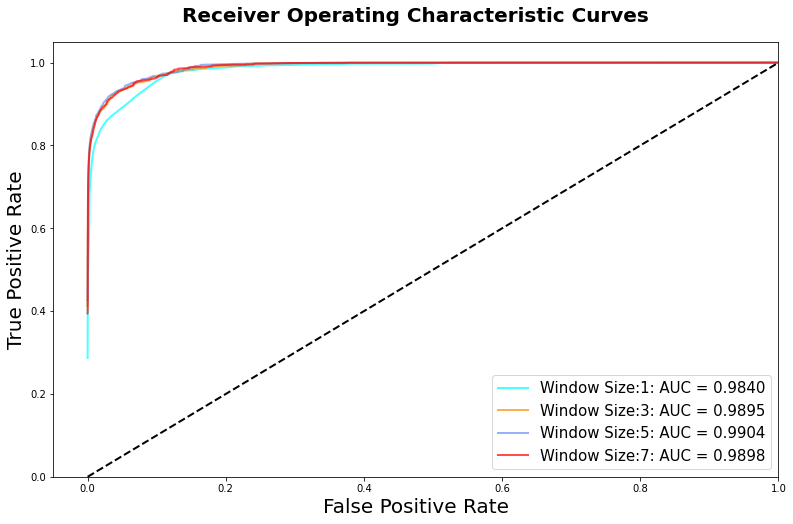

In [0]:
#Plot ROC Curves for different Window Sizes
methods={0:"Window Size:1", 1:"Window Size:3", 2:"Window Size:5", 3:"Window Size:7"}

plt.figure(figsize=(13, 8))
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
windows = [1,3,5,7]
for i, color in zip(range(4), colors):
    #load model based on window size
    model = load_model(f'/content/gdrive/My Drive/Fasttext/Model_weights/model_window_{windows[i]}.h5')
    #prepare data
    x_test, y_test = convert_to_window_dataset([x_test_tokenized, y_test_tokenized], windows[i], train_vocab['__PADDING__'])
    #predict
    predictions = model.predict(x_test)
    #find macro fpr tpr and auc
    fpr, tpr, roc_auc = macro_ROC(y_test, predictions)
    plt.plot(fpr, tpr, color=color, lw=lw, alpha = 0.7,
             label=f'{methods[i]}: AUC = {roc_auc:0.4f}')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic Curves', pad = 20,fontsize=20,weight="bold")
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

### Precsion Recall Curves
***

In [0]:
def macro_precision_recall(y_true, y_pred):
  """
    Gets true y and predictions and returns macro Precision and Recall
  """ 

  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()

  # y_true to 1-hot
  y_true = to_categorical(y_true, num_classes=17)

  # A macro-average score on all classes jointly
  precision_macro, recall_macro, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
  auc_pr_r = auc(recall_macro, precision_macro)

  return precision_macro, recall_macro, auc_pr_r

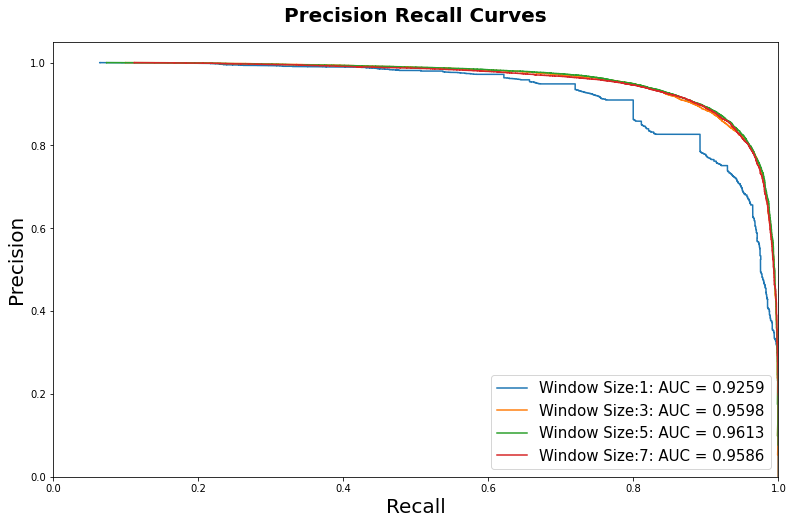

In [0]:
#Plot Precision Recall Curves for different Window Sizes
methods={0:"Window Size:1", 1:"Window Size:3", 2:"Window Size:5", 3:"Window Size:7"}

plt.figure(figsize=(13, 8))
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
windows = [1,3,5,7]
for i, color in zip(range(4), colors):
    #load model based on window size
    model = load_model(f'/content/gdrive/My Drive/Fasttext/Model_weights/model_window_{windows[i]}.h5')
    #prepare data
    x_test, y_test = convert_to_window_dataset([x_test_tokenized, y_test_tokenized], windows[i], train_vocab['__PADDING__'])
    #predict
    predictions = model.predict(x_test)
    #find macro fpr tpr and auc
    pr, re, auc_pr_r = macro_precision_recall(y_test, predictions)
    plt.step(pr, re, where='post',label=f'{methods[i]}: AUC = {auc_pr_r:0.4f}')

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curves', pad = 20, fontsize=20, weight="bold")
plt.legend(loc="lower right", prop={'size': 15})
plt.show()